In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%matplotlib inline
import talib as tb
import numpy as np
import sys
import numpy as np
import seaborn as sns
#try:
#    import pandas as pd
#    import pandas_datareader.data as pdr
#except:
#    import pandas as pd
#    pd.core.common.is_list_like = pd.api.types.is_list_like
#    import pandas_datareader.data as pdr
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as pdr

import fix_yahoo_finance as yf
import xgboost
from xgboost import XGBClassifier
from time import sleep
from datetime import datetime as dt
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.model_selection import train_test_split
# Libraries required by FeatureSelector()
import lightgbm as lgb
import gc
from itertools import chain

In [3]:
# Range of date to train and predict
START = datetime(2008, 9, 1)
END = datetime(2018, 12, 4)

## Data Preprocessing

In [1]:
class Data: 
    def __init__(self, symbol):
        self.q = symbol
        self._get_daily_data()
        self.technical_indicators_df()
        
    def _get_daily_data(self):
        """
        This class prepares data by downloading historical data from Yahoo Finance,

        """
        flag = False
        # Set counter for download trial
        counter = 0

        # Safety loop to handle unstable Yahoo finance download
        while not flag and counter < 6:
            try:
                # Define data range
                yf.pdr_override()
                self.daily_data = pdr.get_data_yahoo(self.q, START, END)
                flag = True

            except:
                flag = False
                counter += 1

                if counter < 6:
                    continue
                else:
                    raise Exception("Yahoo finance is down, please try again later. ")

    def technical_indicators_df(self):
        o = self.daily_data['Open'].values
        c = self.daily_data['Close'].values
        h = self.daily_data['High'].values
        l = self.daily_data['Low'].values
        v = self.daily_data['Volume'].astype(float).values
        # define the technical analysis matrix

        ta = pd.DataFrame()
        ta['MA5'] = tb.MA(c, timeperiod=5)
        ta['MA10'] = tb.MA(c, timeperiod=10)
        ta['MA20'] = tb.MA(c, timeperiod=20)
        ta['MA60'] = tb.MA(c, timeperiod=60)
        ta['MA120'] = tb.MA(c, timeperiod=120)
        ta['MA5'] = tb.MA(v, timeperiod=5)
        ta['MA10'] = tb.MA(v, timeperiod=10)
        ta['MA20'] = tb.MA(v, timeperiod=20)
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14)
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14)
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0]
        ta['RSI'] = tb.RSI(c, timeperiod=14)
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0]
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1]
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]
        ta['AD'] = tb.AD(h, l, c, v)
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14)
        ta['HT_DC'] = tb.HT_DCPERIOD(c)

        self.ta = ta
    
    def label(self, df, seq_length):            
        return (df['Returns'] > 0).astype(int)
    
    def preprocessing(self):
        
        self.daily_data['Returns'] = pd.Series((self.daily_data['Close'] / self.daily_data['Close'].shift(1) - 1)*100, index=self.daily_data.index)
        seq_length = 3
        self.daily_data['Volume'] = self.daily_data['Volume'].astype(float)
        self.X = self.daily_data[['Open', 'Close', 'High', 'Low', 'Volume']]
        self.y = self.label(self.daily_data, seq_length)
        X_shift = [self.X]
        for i in range(1,seq_length):
            X_shift.append(self.daily_data[['Open', 'Close', 'High', 'Low', 'Volume']].shift(i))
        ohlc = pd.concat(X_shift, axis=1)
        ohlc.columns = sum([[c + 'T-{}'.format(i) for c in ['Open', 'Close', 'High', 'Low', 'Volume']] \
                    for i in range(seq_length)], [])
        self.ta.index = ohlc.index
        self.X = pd.concat([ohlc,self.ta], axis=1)
        self.Xy = pd.concat([self.X,self.y], axis=1)
        
        fs = FeatureSelector(data=self.X, labels=self.y)
        fs.identify_all(selection_params={'missing_threshold': 0.6,
                                          'correlation_threshold': 0.9,
                                          'task': 'regression',
                                          'eval_metric': 'auc',
                                          'cumulative_importance': 0.99})
        self.X_fs = fs.remove(methods='all', keep_one_hot=True)
        self.Xy_fs = pd.concat([self.X_fs,self.y], axis=1)
        
        X_train, X_test, y_train, y_test = train_test_split(self.X_fs, self.y, test_size=0.2, random_state=42)
        
        return X_train, y_train, X_test, y_test

In [5]:
stock_data = Data("AAPL")
X_train, y_train, X_test, y_test = stock_data.preprocessing()
X, y, Xy, Xy_fs = stock_data.X, stock_data.y, stock_data.Xy, stock_data.Xy_fs

[*********************100%***********************]  1 of 1 downloaded
0 features with greater than 0.60 missing values.

0 features with a single unique value.

20 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	valid_0's l2: 0.175074	valid_0's auc: 0.814487
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 0.201413	valid_0's auc: 0.755138
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	valid_0's l2: 0.221611	valid_0's auc: 0.712129
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[32]	valid_0's l2: 0.21673	valid_0's auc: 0.713559
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[241]	valid_0's l2: 0.199827	valid_0's auc: 0

Missing values, low importance and removal of correlated features are handled by FeatureSelection() class in which 20 features out of 30 features are removed. 

#### Original features 

In [6]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2583 entries, 2008-09-02 to 2018-12-03
Data columns (total 31 columns):
OpenT-0      2583 non-null float64
CloseT-0     2583 non-null float64
HighT-0      2583 non-null float64
LowT-0       2583 non-null float64
VolumeT-0    2583 non-null float64
OpenT-1      2582 non-null float64
CloseT-1     2582 non-null float64
HighT-1      2582 non-null float64
LowT-1       2582 non-null float64
VolumeT-1    2582 non-null float64
OpenT-2      2581 non-null float64
CloseT-2     2581 non-null float64
HighT-2      2581 non-null float64
LowT-2       2581 non-null float64
VolumeT-2    2581 non-null float64
MA5          2579 non-null float64
MA10         2574 non-null float64
MA20         2564 non-null float64
MA60         2524 non-null float64
MA120        2464 non-null float64
ADX          2556 non-null float64
ADXR         2543 non-null float64
MACD         2550 non-null float64
RSI          2569 non-null float64
BBANDS_U     2579 non-null float64


#### Selected features

In [7]:
Xy_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2583 entries, 2008-09-02 to 2018-12-03
Data columns (total 11 columns):
OpenT-0      2583 non-null float64
VolumeT-0    2583 non-null float64
VolumeT-1    2582 non-null float64
VolumeT-2    2581 non-null float64
ADX          2556 non-null float64
MACD         2550 non-null float64
RSI          2569 non-null float64
AD           2583 non-null float64
ATR          2569 non-null float64
HT_DC        2551 non-null float64
Returns      2583 non-null int32
dtypes: float64(10), int32(1)
memory usage: 232.1 KB


In [8]:
Xy_fs.describe()

,OpenT-0,VolumeT-0,VolumeT-1,VolumeT-2,ADX,MACD,RSI,AD,ATR,HT_DC,Returns
count,2583.000000,2.583000e+03,2.582000e+03,2.581000e+03,2556.000000,2550.000000,2569.000000,2.583000e+03,2569.000000,2551.000000,2583.000000
mean,88.579182,9.433243e+07,9.435316e+07,9.437440e+07,26.242078,0.494561,55.366967,4.197936e+09,1.782883,22.587542,0.524197
std,51.061515,7.706971e+07,7.707743e+07,7.708481e+07,11.301751,1.775115,13.261220,2.018410e+09,1.034557,5.325949,0.499511
min,11.341429,1.147590e+07,1.147590e+07,1.147590e+07,7.809219,-11.052513,18.508762,-1.928084e+09,0.434350,13.341348,0.000000
25%,48.751428,3.769160e+07,3.768255e+07,3.767350e+07,17.967079,-0.286812,45.926868,4.152783e+09,1.046284,18.616218,0.000000
50%,82.571426,7.470890e+07,7.471030e+07,7.471170e+07,23.910202,0.467531,54.738797,4.812280e+09,1.577380,21.762989,1.000000
75%,117.014999,1.234040e+08,1.234182e+08,1.234324e+08,31.936921,1.351764,65.171747,5.591742e+09,2.321966,25.375137,1.000000
max,230.779999,6.555143e+08,6.555143e+08,6.555143e+08,74.056927,7.077562,90.402156,6.996473e+09,7.390591,43.985593,1.000000


In [9]:
Xy_fs[100:105]

,OpenT-0,VolumeT-0,VolumeT-1,VolumeT-2,ADX,MACD,RSI,AD,ATR,HT_DC,Returns
Date,,,,,,,,,,,
2009-01-26,12.694285,173059600.0,190942500.0,352382100.0,15.050362,-0.208835,51.958428,-1.079064e+09,0.604716,18.000227,1
2009-01-27,12.884286,154509600.0,173059600.0,190942500.0,14.716479,-0.148686,53.553115,-1.064551e+09,0.581011,17.574518,1
2009-01-28,13.160000,215351500.0,154509600.0,173059600.0,15.216253,-0.060322,58.298764,-9.476453e+08,0.583082,17.142254,1
2009-01-29,13.298572,148182300.0,215351500.0,154509600.0,15.680329,-0.004079,56.161702,-1.027699e+09,0.559188,16.725546,0
2009-01-30,13.228572,162869700.0,148182300.0,215351500.0,15.248735,0.007326,51.316632,-1.179740e+09,0.556083,16.467464,0


## Exploratory Data Analysis

In [10]:
class Display:
    
    def __init__(self, Xy, Xy_fs):
        self.Xy = Xy
        self.Xy_fs = Xy_fs
       
    def features_histograms(self):
        self.Xy.hist(bins=50, figsize=(20,15), color='darkgreen')
        plt.show()
    
    def plot_corr_heatmap(self): 
        f,ax = plt.subplots(figsize=(20, 20))
        sns.heatmap(self.Xy.iloc[:, 0:-1].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
        
    
    def plot_corr_heatmap_fs(self): 
        f,ax = plt.subplots(figsize=(20, 20))
        sns.heatmap(self.Xy_fs.iloc[:, 0:-1].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Richness of data as demonstrated by histograms of every features and label

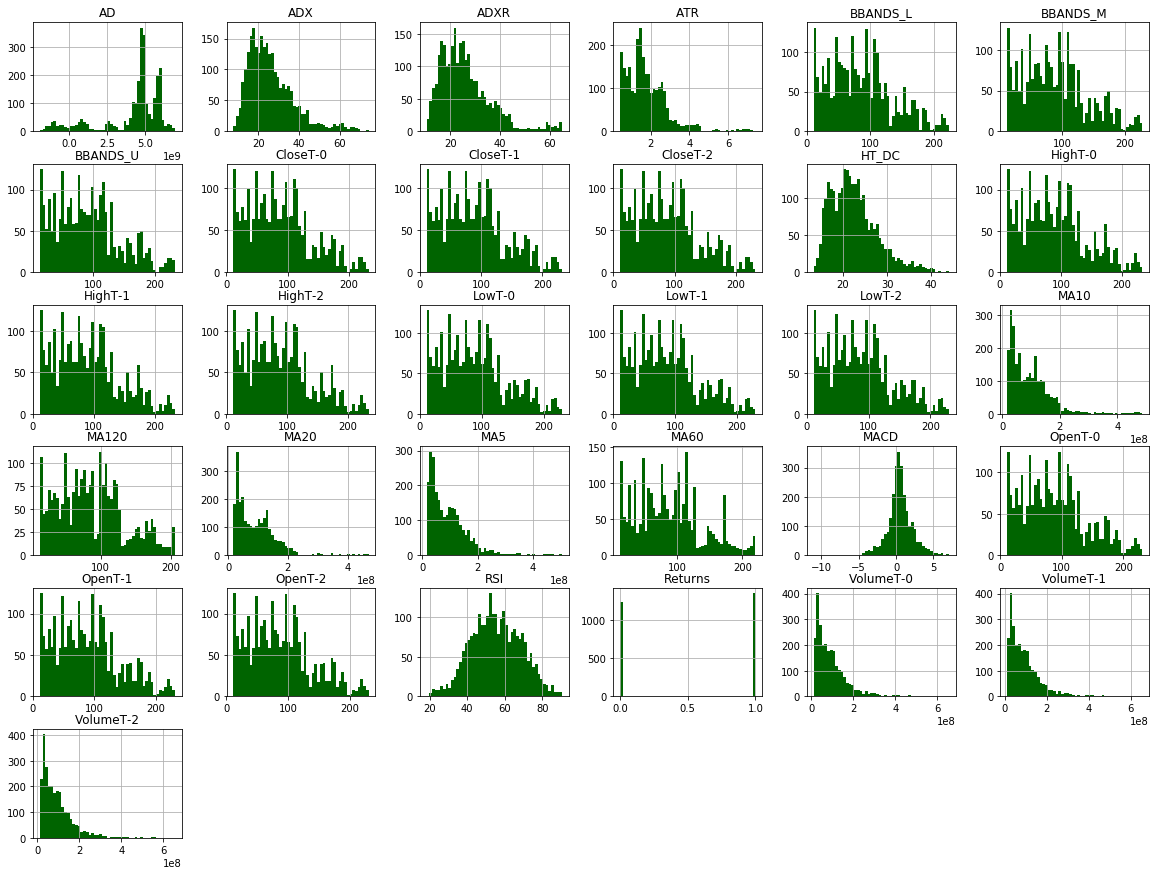

In [11]:
plot = Display(Xy, Xy_fs)
plot.features_histograms()

#### The original dataset with 30 features, likely causing lots of redundant learning and costing computational resources

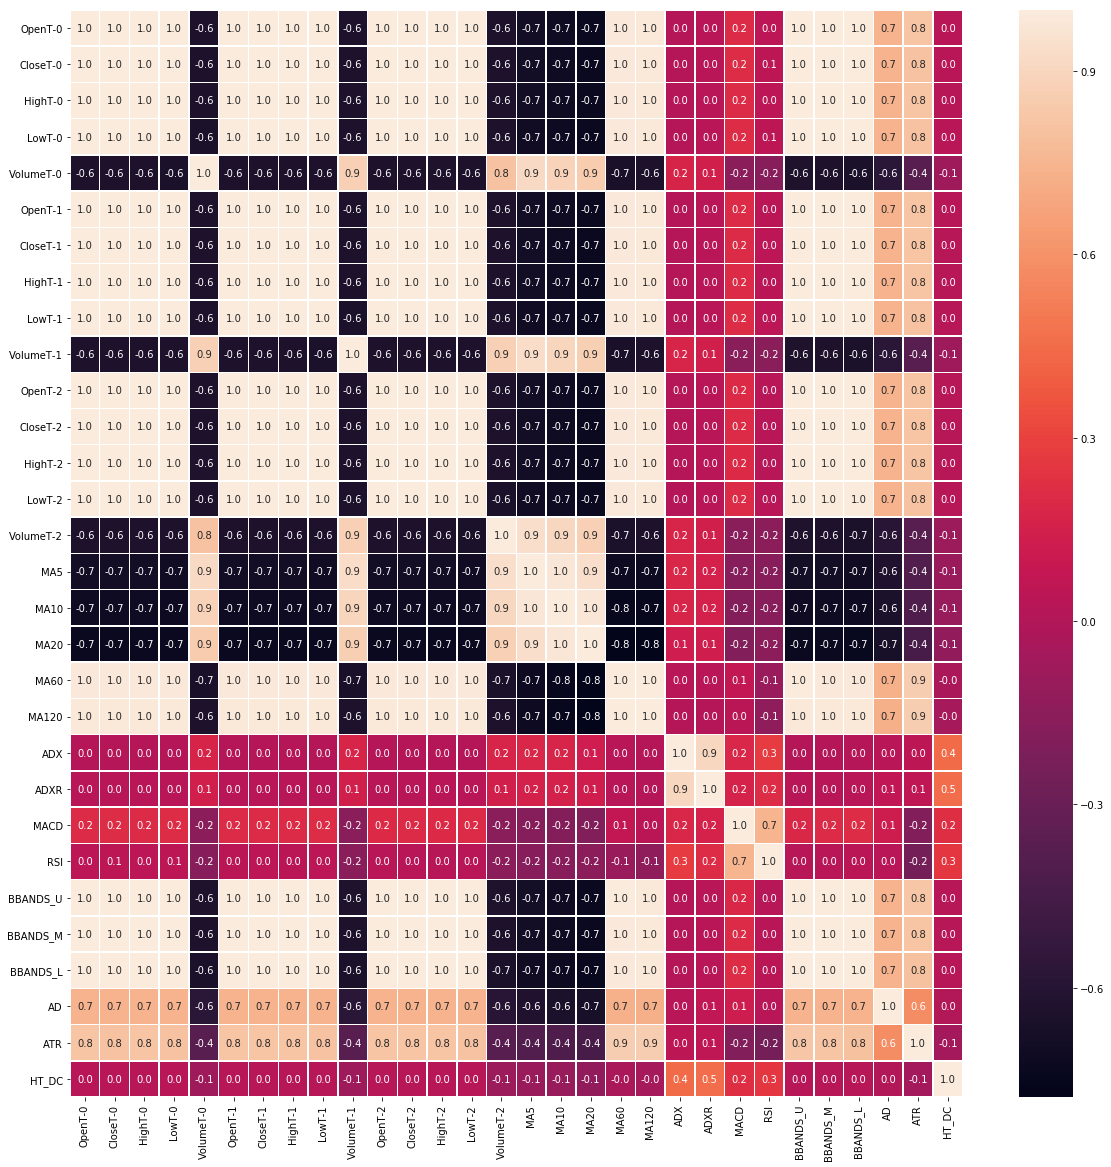

In [12]:
plot.plot_corr_heatmap()

#### 10 Selected features correlations with each other 

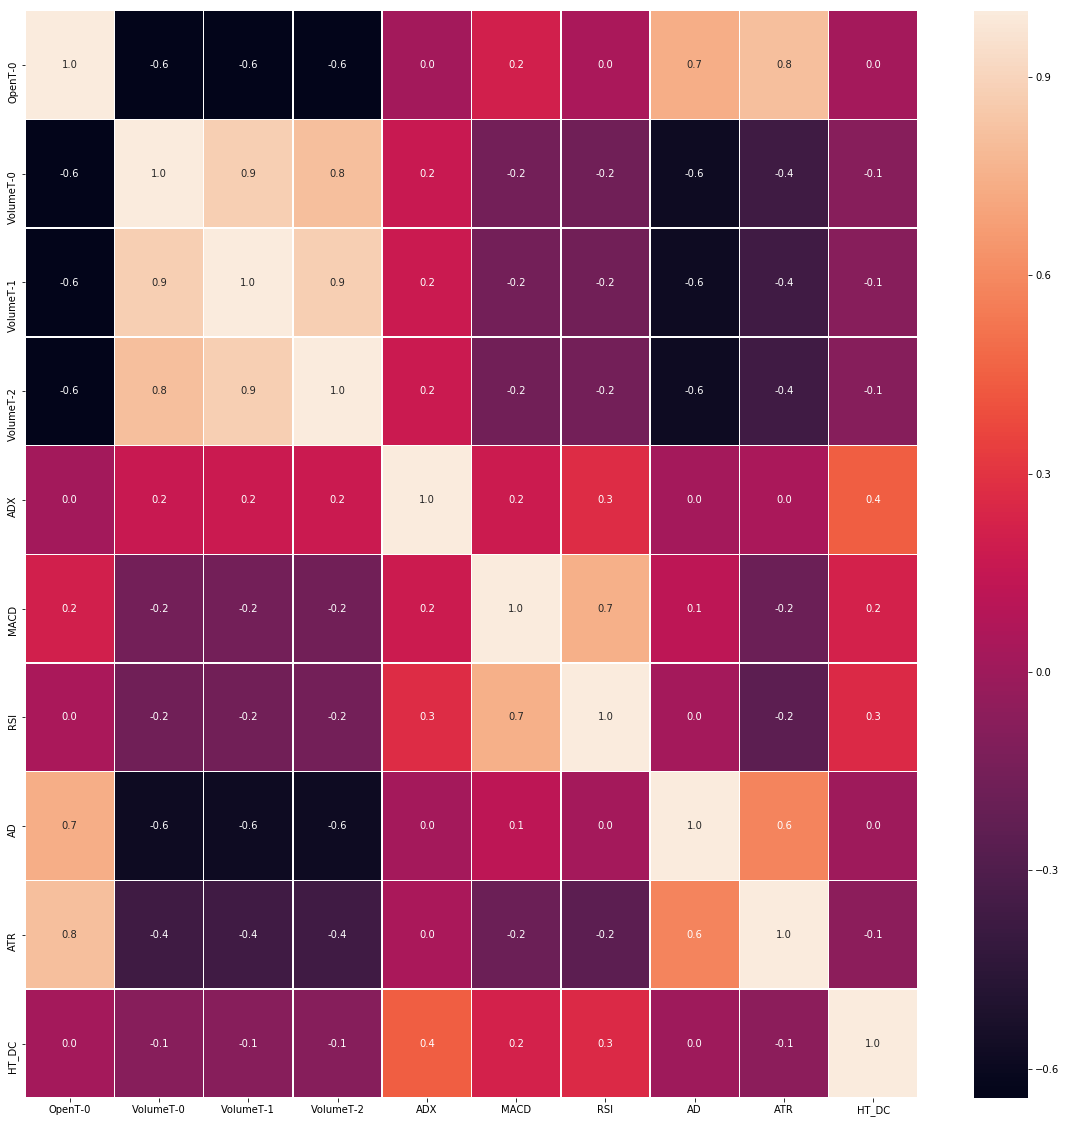

In [13]:
plot.plot_corr_heatmap_fs()

In [14]:
class XGB_training:
    def __init__(self, Xtrain, ytrain, Xtest, ytest):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.training()
        self._metric = ['error', 'logloss', 'auc']

    def calc_metrics(self, model):
        """
        This function fits model and returns the RMSE for in-sample error and out-of-sample error
        """
        train_error, train_score = self.calc_train_error(model)
        validation_error, validation_score = self.calc_validation_error(model)

        print("\n")
        print("Train MSE: ", train_error)
        print("Train Score: ", train_score)
        print("Test MSE", validation_error)
        print("Test Score", validation_score)

        return train_error, validation_error, train_score, validation_score

    def calc_train_error(self, model):
        """
        This function returns in-sample error for already fit model.
        """
        predictions = model.predict(self.Xtrain)
        mse = mean_squared_error(self.ytrain, predictions)
        score = accuracy_score(self.ytrain, predictions)
        return mse, score

    def calc_validation_error(self, model):
        """
        This function returns out-of-sample error for already fit model.
        """
        predictions = model.predict(self.Xtest)
        mse = mean_squared_error(self.ytest, predictions)
        score = accuracy_score(self.ytest, predictions)
        return mse, score
    
    
    def training(self):
        metric = ['error', 'logloss', 'auc']
        
        n_estimators = [0,1,2,3,4,5,6,7,8,9,10,14,29,64,128,256,512,1024,1200,1500,2056]
        max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15]
        best_depth = 0
        best_estimator = 0
        max_score = 0    
        #model = XGBClassifier()
        for n in n_estimators:
            for md in max_depth:   
                dtrain = xgboost.DMatrix(self.Xtrain, self.ytrain)
                self.param_grid = dict(
                               #base_score=0.5,
                               #scale_pos_weight=1,
                               #learning_rate=0.001,
                               #gamma=0,
                               #min_child_weight=1,
                               #max_delta_step=0,
                               #subsample=1,
                               #colsample_bytree=1,
                               #colsample_bylevel=1,
                               #reg_lambda=1,
                               #reg_alpha=0,
                               n_estimators=n, 
                               max_depth=md,
                               silent=1
                              )                             
                cvresult = xgboost.cv(self.param_grid, 
                                      dtrain, nfold=2, 
                                      metrics=metric,
                                      stratified=True)
                print (cvresult.shape[0])
                #model.set_params(n_estimators=cvresult.shape[0])
                """
                model = XGBClassifier(n_estimators=n, max_depth=md, reg_alpha=0, reg_lambda=1)
                """
                model.fit(self.Xtrain, 
                          self.ytrain, 
                          eval_metric = metric,
                          eval_set=[(self.Xtrain, self.ytrain), (self.Xtest, self.ytest)],
                          verbose=False)
                y_pred = model.predict(self.Xtest)
                score = accuracy_score(self.ytest, y_pred)
                mse = mean_squared_error(self.ytest, y_pred)
                y_pred_tr = model.predict(self.Xtrain)
                mse_tr = mean_squared_error(self.ytrain, y_pred_tr)
               
                if score > max_score:
                    max_score = score
                    min_mse = mse
                    best_depth = md
                    best_estimator = n
                print("Accuracy score: " + str(round(score,4)) + " at depth: " + str(md) + " and estimator " + str(n))
                print("Mean square error: " + str(round(mse,4)) + " at depth: " + str(md) + " and estimator " + str(n))
        print("Best score: " + str(round(max_score,4)) + " Best MSE: " + str(round(min_mse,4)) + " at depth: " + str(best_depth) + " and estimator of " + str(best_estimator))
        
        self.best_xgb = model
        
    def predict(self):
        """
        Predicts the labels for the original test set
        """
        print("Best XGB model:")
        print(self.best_xgb.get_xgb_params())
        self.calc_metrics(self.best_xgb)
                
        # plot boosting results
        results = self.best_xgb.evals_result()
        epochs = len(results['validation_0'][self._metric[0]])
        x_axis = range(0, epochs)
        plt.style.use('ggplot')
        plt.rcParams['font.size'] = 8
        plt.figure(figsize=(30, 15))
        i = 0
        for m in self._metric:
            ax = plt.subplot2grid((len(self._metric), 2), (i, 0))
            i += 1
            ax.plot(x_axis, results['validation_0'][m], label='Train')
            ax.plot(x_axis, results['validation_1'][m], label='Test')
            ax.legend()
            ax.set_ylabel(m)
        
        # plot feature importances
        ax = xgboost.plot_importance(self.best_xgb.get_booster())
        fig = ax.figure
        fig.set_size_inches(14, 8)
        
        # plot tree
        ax = xgboost.plot_tree(self.best_xgb.get_booster(), num_trees=4)
        #ax = xgboost.to_graphviz(bst, num_trees=2)
        fig = ax.figure
        fig.set_size_inches(300, 100)
        plt.savefig('tree.png', bbox_inches='tight')

In [17]:
model = XGBClassifier()
metric = ['error', 'logloss', 'auc']
dtrain = xgboost.DMatrix(X_train, y_train)
param_grid = dict(
               #base_score=0.5,
               #scale_pos_weight=1,
               #learning_rate=0.001,
               #gamma=0,
               #min_child_weight=1,
               #max_delta_step=0,
               #subsample=1,
               #colsample_bytree=1,
               #colsample_bylevel=1,
               #reg_lambda=1,
               #reg_alpha=0,
               n_estimators=8, 
               max_depth=1,
               silent=1
              )                             
cvresult = xgboost.cv(param_grid, 
                      dtrain, nfold=4, 
                      metrics=metric,
                      stratified=True)

model.set_params(n_estimators=cvresult.shape[0])
"""
model = XGBClassifier(n_estimators=n, max_depth=md, reg_alpha=0, reg_lambda=1)
"""
model.fit(X_train, y_train, 
          eval_metric = metric,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)

In [18]:
from sklearn.model_selection import cross_val_score
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1,
                     gamma=0, subsample=0.8, colsample_bytree=0.1, random_state=42)
xgb_param = xgb1.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
# X, y is the train predictors and target

# Iteration will train until cv error hasn't decreased in 50 rounds.
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=1000, early_stopping_rounds=50, 
                  nfold=5, metrics = 'auc', stratified=True, shuffle=True, seed=42, 
                  verbose_eval=False)
print("There are {} trees in our model. CV-mean: {:.4f}, CV-std: {:.4f}.".format(
        cvresult.shape[0], cvresult.iloc[cvresult.shape[0]-1, 0], 
        cvresult.iloc[cvresult.shape[0]-1, 1]))

xgb1.set_params(n_estimators=cvresult.shape[0])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(xgb1, X_train, y_train, scoring='roc_auc', cv=skf)
print("ROC-AUC (CV+/std): {:.4f}+-{:.4f}".format(score.mean(),score.std()) )

There are 85 trees in our model. CV-mean: 0.5911, CV-std: 0.0306.
ROC-AUC (CV+/std): 0.5838+-0.0263


In [19]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
xgb_clf = XGB_training(X_train, y_train, X_test, y_test)

10
Accuracy score: 0.6809 at depth: 1 and estimator 0
Mean square error: 0.3191 at depth: 1 and estimator 0
10
Accuracy score: 0.6809 at depth: 2 and estimator 0
Mean square error: 0.3191 at depth: 2 and estimator 0
10
Accuracy score: 0.6809 at depth: 3 and estimator 0
Mean square error: 0.3191 at depth: 3 and estimator 0
10
Accuracy score: 0.6809 at depth: 4 and estimator 0
Mean square error: 0.3191 at depth: 4 and estimator 0
10
Accuracy score: 0.6809 at depth: 5 and estimator 0
Mean square error: 0.3191 at depth: 5 and estimator 0
10
Accuracy score: 0.6809 at depth: 6 and estimator 0
Mean square error: 0.3191 at depth: 6 and estimator 0
10
Accuracy score: 0.6809 at depth: 7 and estimator 0
Mean square error: 0.3191 at depth: 7 and estimator 0
10
Accuracy score: 0.6809 at depth: 8 and estimator 0
Mean square error: 0.3191 at depth: 8 and estimator 0
10
Accuracy score: 0.6809 at depth: 9 and estimator 0
Mean square error: 0.3191 at depth: 9 and estimator 0
10
Accuracy score: 0.6809 at

10
Accuracy score: 0.6809 at depth: 4 and estimator 5
Mean square error: 0.3191 at depth: 4 and estimator 5
10
Accuracy score: 0.6809 at depth: 5 and estimator 5
Mean square error: 0.3191 at depth: 5 and estimator 5
10
Accuracy score: 0.6809 at depth: 6 and estimator 5
Mean square error: 0.3191 at depth: 6 and estimator 5
10
Accuracy score: 0.6809 at depth: 7 and estimator 5
Mean square error: 0.3191 at depth: 7 and estimator 5
10
Accuracy score: 0.6809 at depth: 8 and estimator 5
Mean square error: 0.3191 at depth: 8 and estimator 5
10
Accuracy score: 0.6809 at depth: 9 and estimator 5
Mean square error: 0.3191 at depth: 9 and estimator 5
10
Accuracy score: 0.6809 at depth: 10 and estimator 5
Mean square error: 0.3191 at depth: 10 and estimator 5
10
Accuracy score: 0.6809 at depth: 11 and estimator 5
Mean square error: 0.3191 at depth: 11 and estimator 5
10
Accuracy score: 0.6809 at depth: 12 and estimator 5
Mean square error: 0.3191 at depth: 12 and estimator 5
10
Accuracy score: 0.6

10
Accuracy score: 0.6809 at depth: 6 and estimator 10
Mean square error: 0.3191 at depth: 6 and estimator 10
10
Accuracy score: 0.6809 at depth: 7 and estimator 10
Mean square error: 0.3191 at depth: 7 and estimator 10
10
Accuracy score: 0.6809 at depth: 8 and estimator 10
Mean square error: 0.3191 at depth: 8 and estimator 10
10
Accuracy score: 0.6809 at depth: 9 and estimator 10
Mean square error: 0.3191 at depth: 9 and estimator 10
10
Accuracy score: 0.6809 at depth: 10 and estimator 10
Mean square error: 0.3191 at depth: 10 and estimator 10
10
Accuracy score: 0.6809 at depth: 11 and estimator 10
Mean square error: 0.3191 at depth: 11 and estimator 10
10
Accuracy score: 0.6809 at depth: 12 and estimator 10
Mean square error: 0.3191 at depth: 12 and estimator 10
10
Accuracy score: 0.6809 at depth: 13 and estimator 10
Mean square error: 0.3191 at depth: 13 and estimator 10
10
Accuracy score: 0.6809 at depth: 14 and estimator 10
Mean square error: 0.3191 at depth: 14 and estimator 10


Accuracy score: 0.6809 at depth: 6 and estimator 256
Mean square error: 0.3191 at depth: 6 and estimator 256
10
Accuracy score: 0.6809 at depth: 7 and estimator 256
Mean square error: 0.3191 at depth: 7 and estimator 256
10
Accuracy score: 0.6809 at depth: 8 and estimator 256
Mean square error: 0.3191 at depth: 8 and estimator 256
10
Accuracy score: 0.6809 at depth: 9 and estimator 256
Mean square error: 0.3191 at depth: 9 and estimator 256
10
Accuracy score: 0.6809 at depth: 10 and estimator 256
Mean square error: 0.3191 at depth: 10 and estimator 256
10
Accuracy score: 0.6809 at depth: 11 and estimator 256
Mean square error: 0.3191 at depth: 11 and estimator 256
10
Accuracy score: 0.6809 at depth: 12 and estimator 256
Mean square error: 0.3191 at depth: 12 and estimator 256
10
Accuracy score: 0.6809 at depth: 13 and estimator 256
Mean square error: 0.3191 at depth: 13 and estimator 256
10
Accuracy score: 0.6809 at depth: 14 and estimator 256
Mean square error: 0.3191 at depth: 14 and

Accuracy score: 0.6809 at depth: 3 and estimator 2056
Mean square error: 0.3191 at depth: 3 and estimator 2056
10
Accuracy score: 0.6809 at depth: 4 and estimator 2056
Mean square error: 0.3191 at depth: 4 and estimator 2056
10
Accuracy score: 0.6809 at depth: 5 and estimator 2056
Mean square error: 0.3191 at depth: 5 and estimator 2056
10
Accuracy score: 0.6809 at depth: 6 and estimator 2056
Mean square error: 0.3191 at depth: 6 and estimator 2056
10
Accuracy score: 0.6809 at depth: 7 and estimator 2056
Mean square error: 0.3191 at depth: 7 and estimator 2056
10
Accuracy score: 0.6809 at depth: 8 and estimator 2056
Mean square error: 0.3191 at depth: 8 and estimator 2056
10
Accuracy score: 0.6809 at depth: 9 and estimator 2056
Mean square error: 0.3191 at depth: 9 and estimator 2056
10
Accuracy score: 0.6809 at depth: 10 and estimator 2056
Mean square error: 0.3191 at depth: 10 and estimator 2056
10
Accuracy score: 0.6809 at depth: 11 and estimator 2056
Mean square error: 0.3191 at de

Best XGB model:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


Train MSE:  0.3165537270087125
Train Score:  0.6834462729912875
Test MSE 0.3191489361702128
Test Score 0.6808510638297872


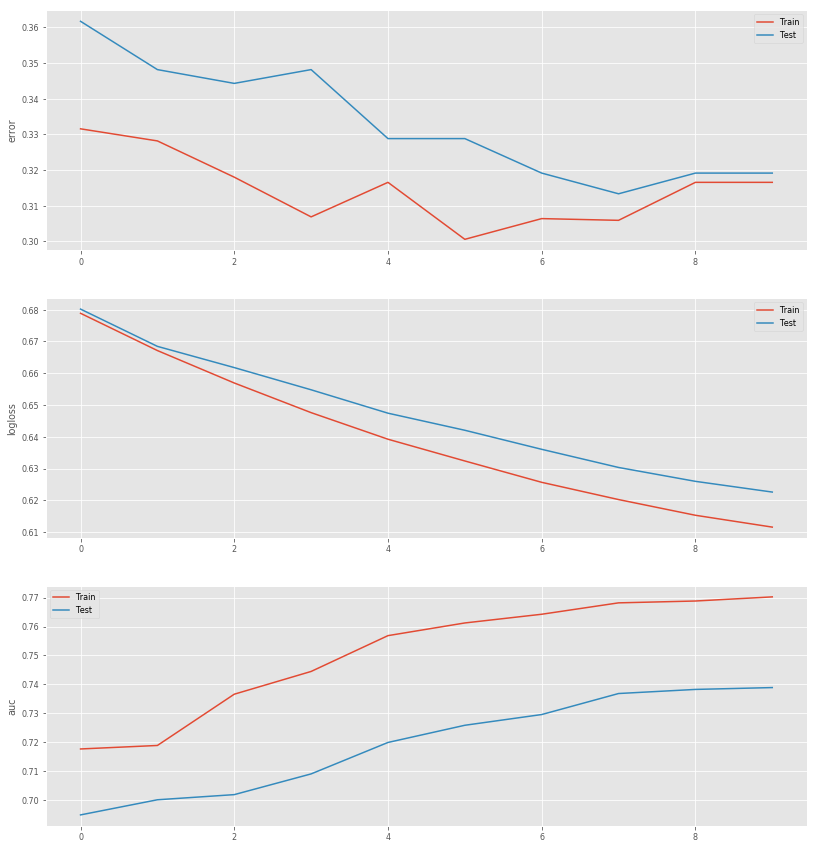

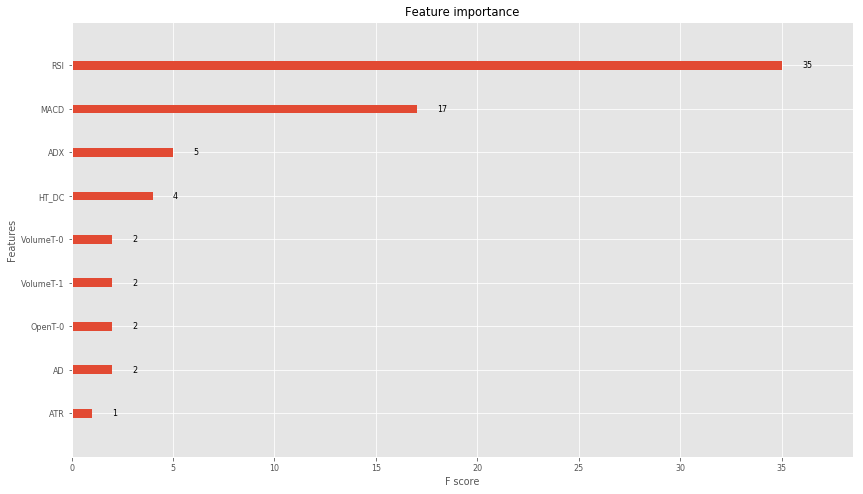

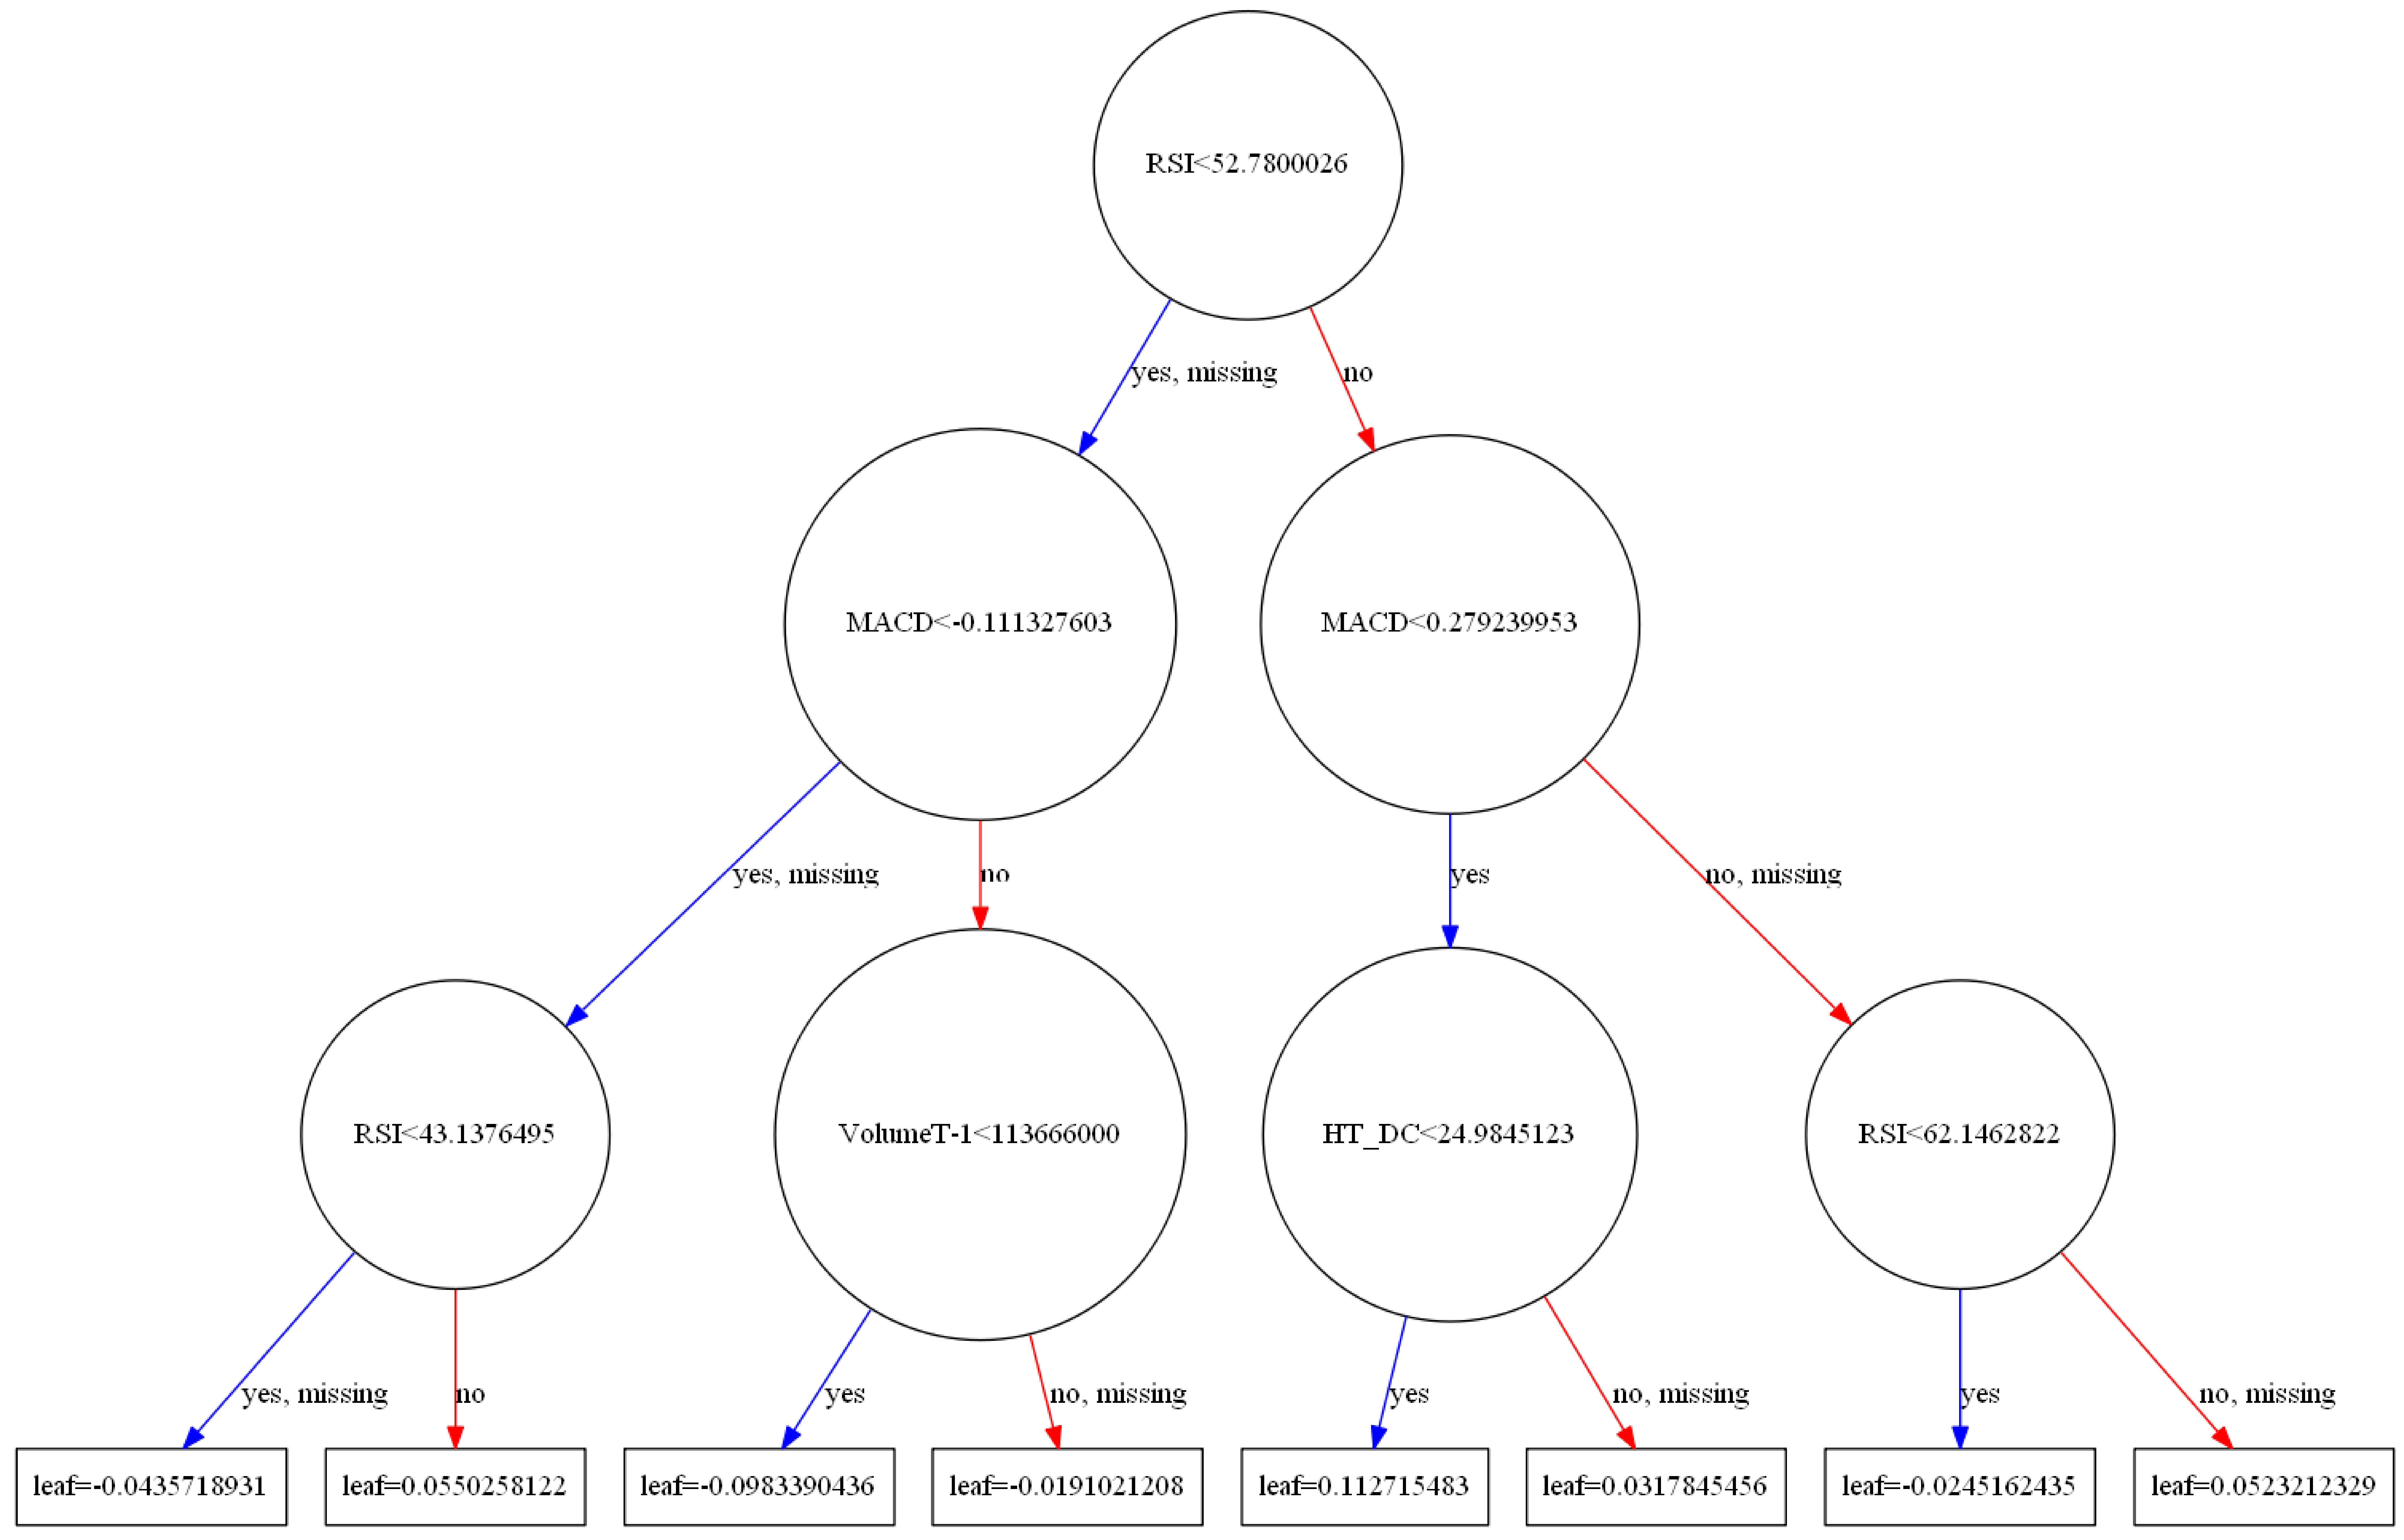

In [21]:
xgb_clf.predict()

Best XGB model:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


Train MSE:  0.30640394088669953
Train Score:  0.6935960591133005
Test MSE 0.33070866141732286
Test Score 0.6692913385826772


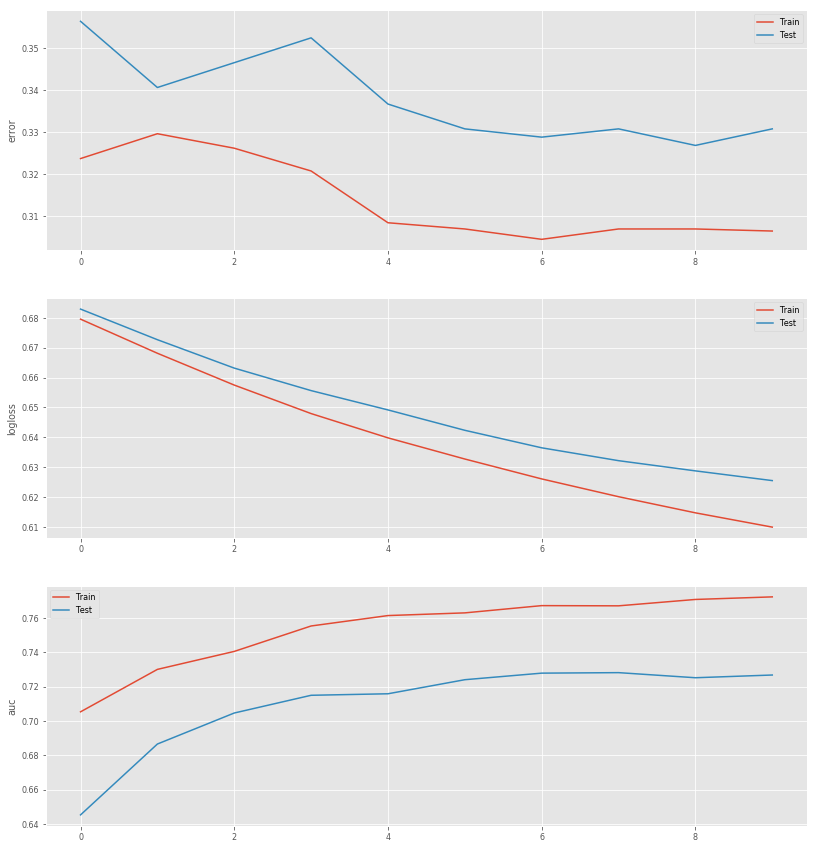

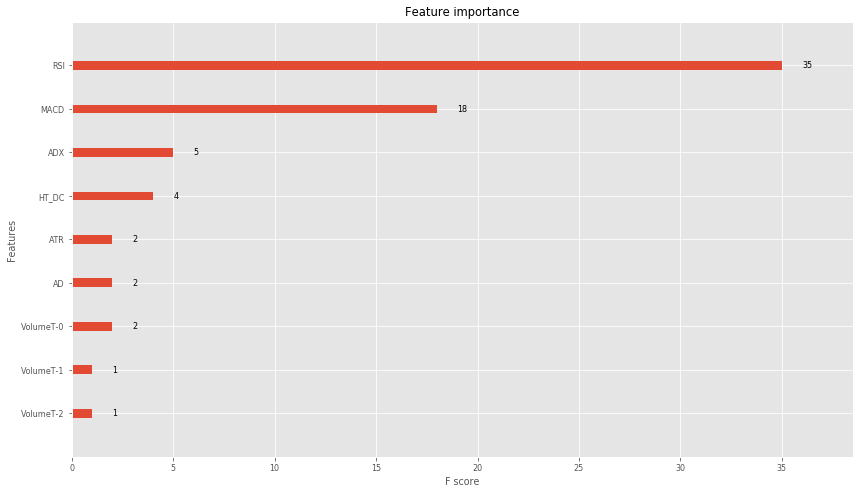

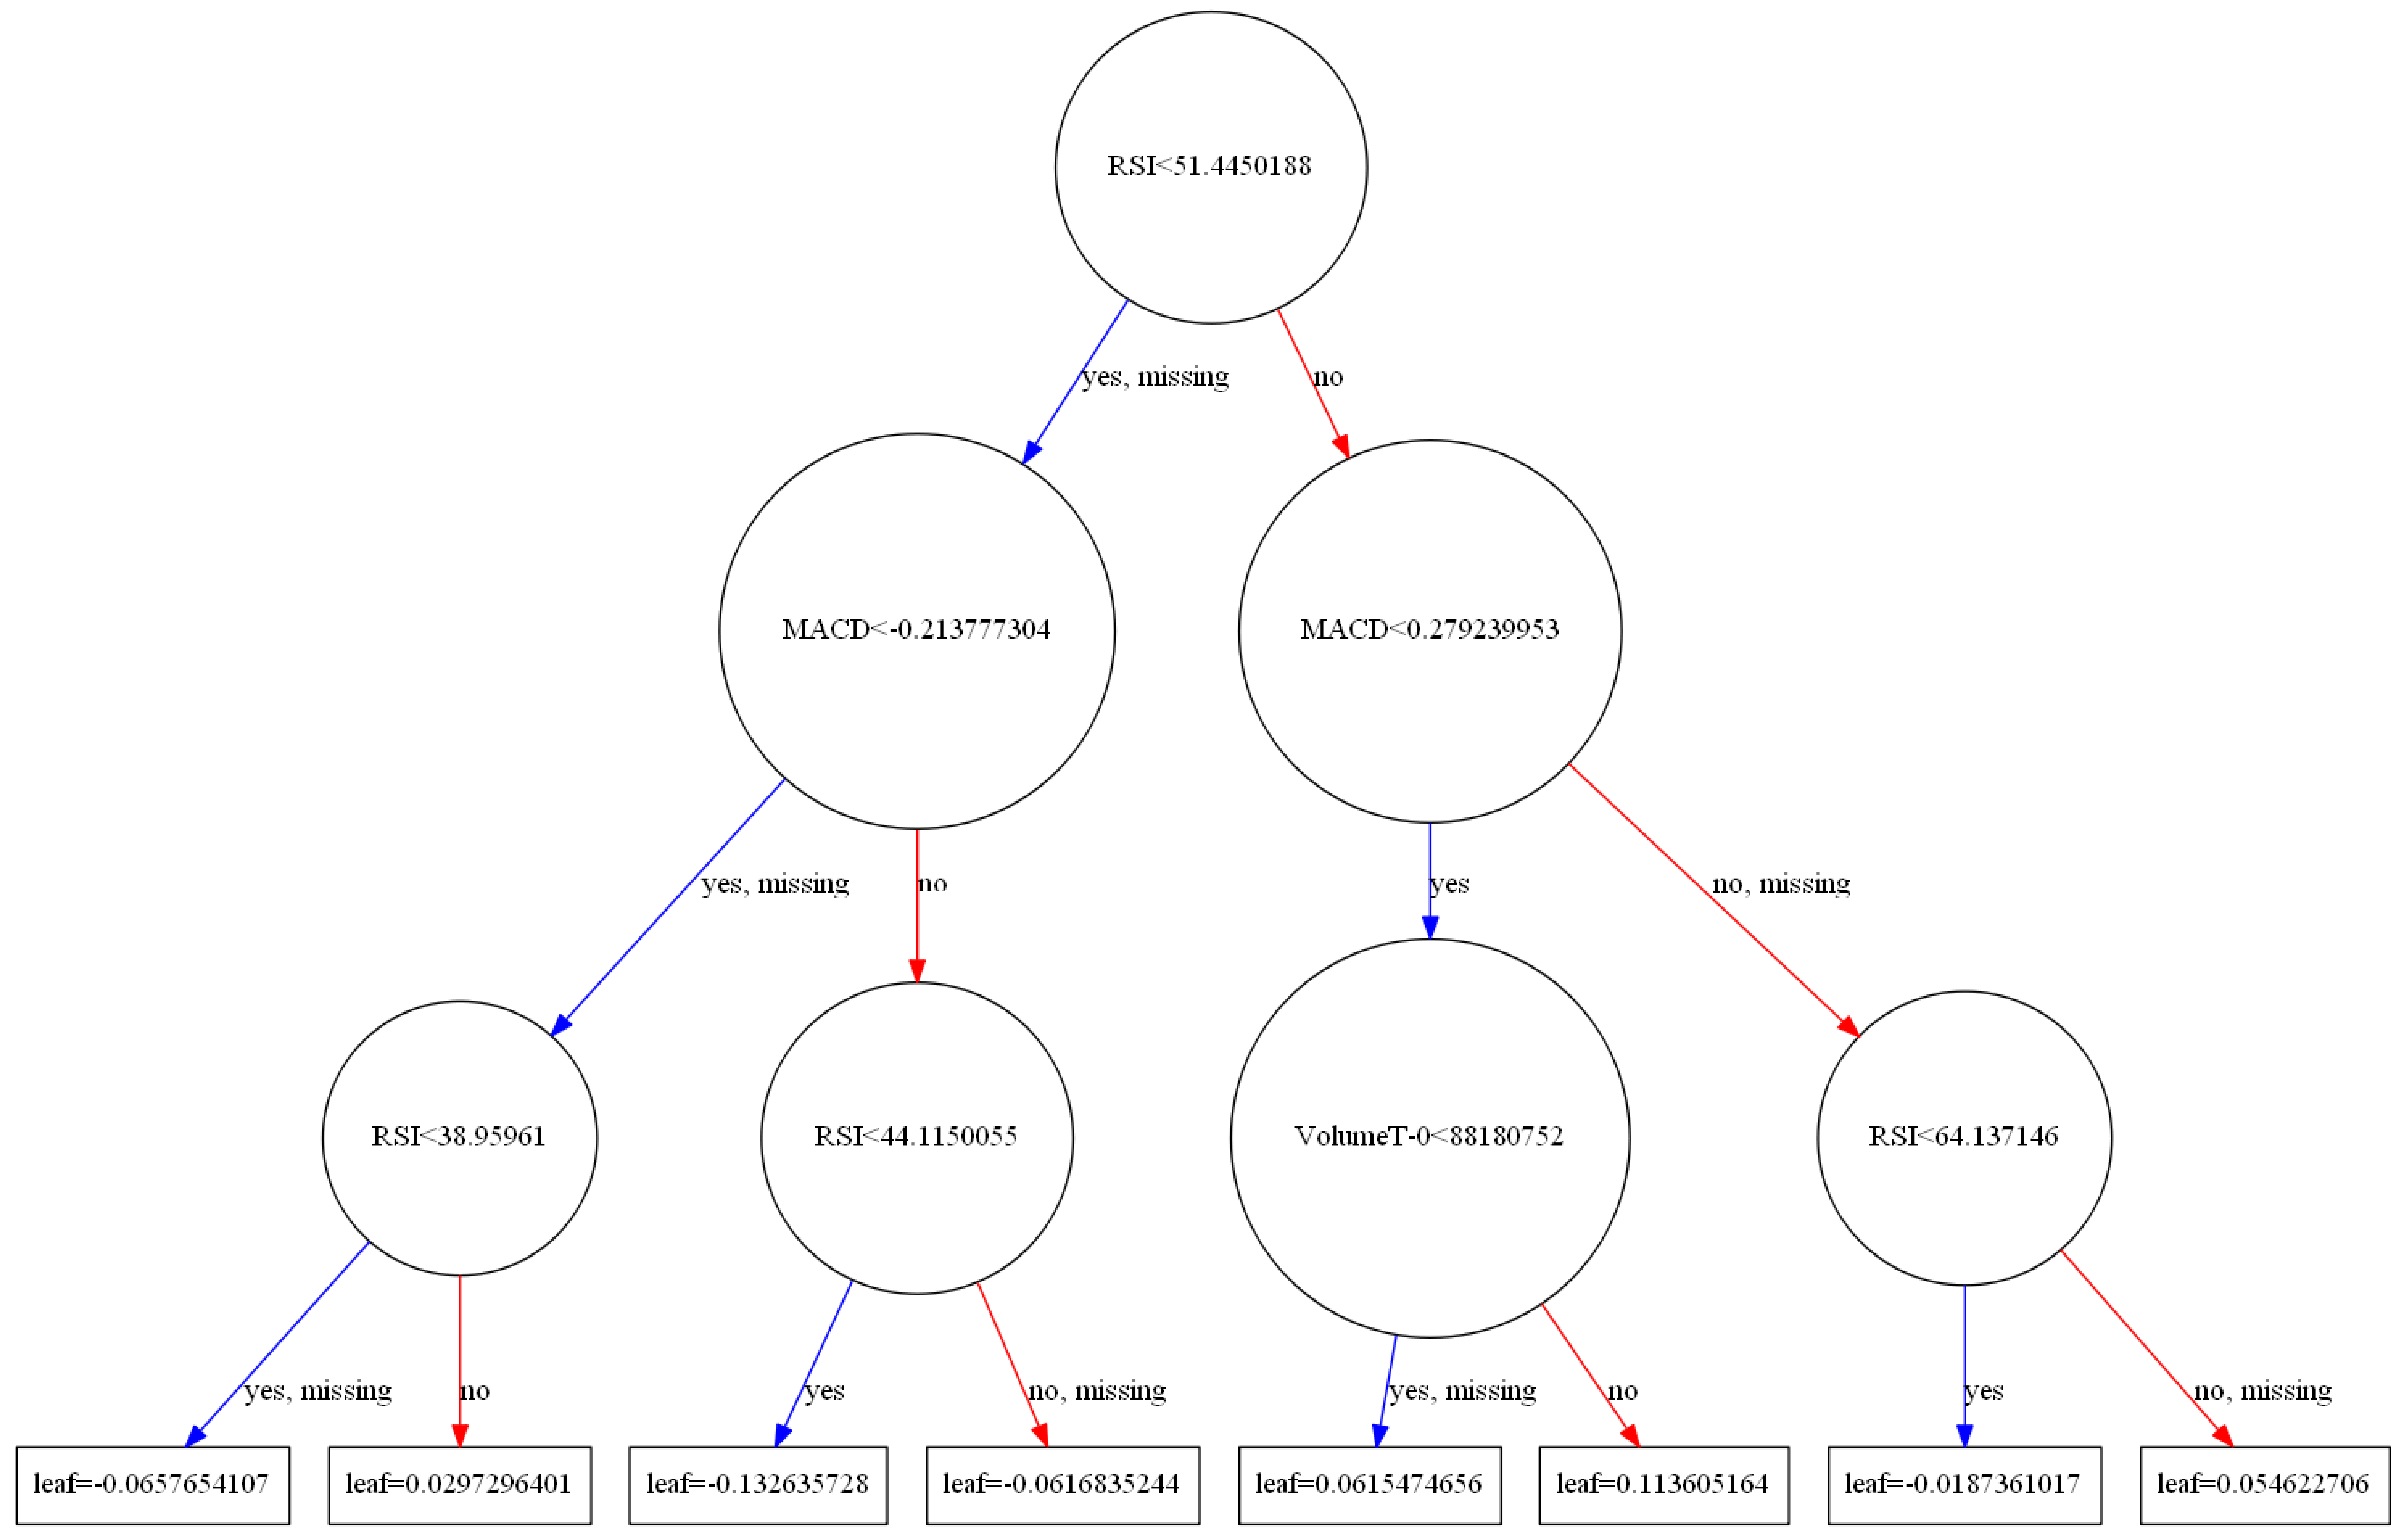

In [76]:
xgb_clf.predict()

## References
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [1]:
class FeatureSelector():
    """
    Courtesy of William Koehrsen from Feature Labs
    Class for performing feature selection for machine learning or data preprocessing.

    Implements five different methods to identify features for removal

        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm

    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns

        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.

    Attributes
    --------

    ops : dict
        Dictionary of operations run and features identified for removal

    missing_stats : dataframe
        The fraction of missing values for all features

    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold

    unique_stats : dataframe
        Number of unique values for all features

    record_single_unique : dataframe
        Records the features that have a single unique value

    corr_matrix : dataframe
        All correlations between all features in the data

    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold

    feature_importances : dataframe
        All feature importances from the gradient boosting machine

    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm

    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm


    Notes
    --------

        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns

    """

    def __init__(self, data, labels=None):

        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')

        self.base_features = list(data.columns)
        self.one_hot_features = None

        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None

        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None

        # Dictionary to hold removal operations
        self.ops = {}

        self.one_hot_correlated = False

    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""

        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns={'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending=False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns=
                                                                                                               {
                                                                                                                   'index': 'feature',
                                                                                                                   0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop

        print('%d features with greater than %0.2f missing values.\n' % (
        len(self.ops['missing']), self.missing_threshold))

    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns={'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending=True)

        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(
            columns={'index': 'feature',
                     0: 'nunique'})

        to_drop = list(record_single_unique['feature'])

        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop

        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))

    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features.
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal.

        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

        Parameters
        --------

        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features

        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients

        """

        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot

        # Calculate the correlations between every column
        if one_hot:

            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis=1)

            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()

        self.corr_matrix = corr_matrix

        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns=['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:
            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                              'corr_feature': corr_features,
                                              'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index=True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop

        print('%d features with a correlation magnitude greater than %0.2f.\n' % (
        len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None,
                                 n_iterations=10, early_stopping=True):
        """

        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting.
        The feature importances are averaged over `n_iterations` to reduce variance.

        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)

        Parameters
        --------

        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True

        task : string
            The machine learning task, either 'classification' or 'regression'

        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine

        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training


        Notes
        --------

        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs

        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")

        if self.labels is None:
            raise ValueError("No training labels provided.")

        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis=1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1,))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))

        print('Training Gradient Boosting Model\n')

        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=-1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, verbose=-1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')

            # If training using early stopping need a validation set
            if early_stopping:

                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels,
                                                                                              test_size=0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric=eval_metric,
                          eval_set=[(valid_features, valid_labels)],
                          early_stopping_rounds=100, verbose=-1)

                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()

            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances[
            'importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]

        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop

        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))

    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to
        reach 95% of the total feature importance. The identified features are those not needed.

        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for

        """

        self.cumulative_importance = cumulative_importance

        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")

        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[
            self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop

        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (
        len(self.feature_importances) -
        len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                      self.cumulative_importance))

    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.

        Parameters
        --------

        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']

        """

        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)

        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task=selection_params['task'], eval_metric=selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])

        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)

        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified,
                                                                                                self.data_all.shape[1]))

    def check_removal(self, keep_one_hot=True):

        """Check the identified features before removal. Returns a list of the unique features identified."""

        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))

        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))

        return list(self.all_identified)

    def remove(self, methods, keep_one_hot=True):
        """
        Remove the features from the data according to the specified methods.

        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features

        Return
        --------
            data : dataframe
                Dataframe with identified features removed


        Notes
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!

        """

        features_to_drop = []

        if methods == 'all':

            # Need to use one-hot encoded data as well
            data = self.data_all

            print('{} methods have been run\n'.format(list(self.ops.keys())))

            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))

        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all

            else:
                data = self.data

            # Iterate through the specified methods
            for method in methods:

                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)

                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])

            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))

        features_to_drop = list(features_to_drop)

        if not keep_one_hot:

            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:

                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))

        # Remove the features and return the data
        data = data.drop(columns=features_to_drop)
        self.removed_features = features_to_drop

        if not keep_one_hot:
            print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
            print('Removed %d features.' % len(features_to_drop))

        return data

    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")

        self.reset_plot()

        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize=(7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins=np.linspace(0, 1, 11), edgecolor='k', color='red',
                 linewidth=1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size=14);
        plt.ylabel('Count of Features', size=14);
        plt.title("Fraction of Missing Values Histogram", size=16);

    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')

        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor='k', figsize=(7, 5))
        plt.ylabel('Frequency', size=14);
        plt.xlabel('Unique Values', size=14);
        plt.title('Number of Unique Values Histogram', size=16);

    def plot_collinear(self, plot_all=False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold

        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis

        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """

        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')

        if plot_all:
            corr_matrix_plot = self.corr_matrix
            title = 'All Correlations'

        else:
            # Identify the correlations that were above the threshold
            # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
            corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])),
                                                    list(set(self.record_collinear['drop_feature']))]

            title = "Correlations Above Threshold"

        f, ax = plt.subplots(figsize=(10, 8))

        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size=int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size=int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size=14)

    def plot_feature_importances(self, plot_n=15, threshold=None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------

        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller

        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """

        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')

        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()

        # Make a horizontal bar chart of feature importances
        plt.figure(figsize=(10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))),
                self.feature_importances['normalized_importance'][:plot_n],
                align='center', edgecolor='k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size=12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size=16);
        plt.title('Feature Importances', size=18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize=(6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'],
                 'r-')
        plt.xlabel('Number of Features', size=14);
        plt.ylabel('Cumulative Importance', size=14);
        plt.title('Cumulative Feature Importance', size=16);

        if threshold:
            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x=importance_index + 1, ymin=0, ymax=1, linestyles='--', colors='blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault